In [1]:
from histocartography.io.wsi import WSI
import matplotlib.pyplot as plt

import numpy as np

import cv2

import seaborn as sns

In [2]:
img = WSI('../datasets/cam16_selected/tumor_105.tif', minimum_tissue_content=.05)

2019-11-01 15:45:59,236 - Histocartography::IO::WSI - DEBUG - wsi_file : ../datasets/cam16_selected/tumor_105.tif
2019-11-01 15:45:59,245 - Histocartography::IO::WSI - DEBUG - Original mag: 1
2019-11-01 15:45:59,247 - Histocartography::IO::WSI - DEBUG - Levels: 9
2019-11-01 15:45:59,248 - Histocartography::IO::WSI - DEBUG - Level dimensions ((106496, 93184), (53248, 46592), (26624, 23296), (13312, 11648), (6656, 5824), (3328, 2912), (1664, 1456), (832, 728), (416, 364))


In [4]:
size = 512
patches = img.patches(mag=1,
                      size=(size, size),
                      stride=(size, size))

2019-11-01 15:10:00,345 - Histocartography::IO::WSI - DEBUG - Level for desired resolution : 0
2019-11-01 15:10:00,346 - Histocartography::IO::WSI - DEBUG - Step size : 512 512
2019-11-01 15:10:00,347 - Histocartography::IO::WSI - DEBUG - Num Patches : 182 208
2019-11-01 15:10:00,360 - Histocartography::IO::WSI - DEBUG - Level for desired resolution : 5
2019-11-01 15:10:00,892 - Histocartography::IO::WSI - DEBUG - Image shape after loading (2912, 3328, 3)
2019-11-01 15:10:00,944 - Histocartography::IO::WSI - DEBUG - THRESHOLD: 83.0  -- Darkest: 219, Brightest: 239, Average: 230.37942504882812
2019-11-01 15:10:00,945 - Histocartography::IO::WSI - DEBUG - Region 0,0 has 0.0 pixels ratio
2019-11-01 15:10:00,974 - Histocartography::IO::WSI - DEBUG - THRESHOLD: 83.0  -- Darkest: 128, Brightest: 252, Average: 230.3307991027832
2019-11-01 15:10:00,977 - Histocartography::IO::WSI - DEBUG - Region 0,512 has 0.0 pixels ratio
2019-11-01 15:10:01,006 - Histocartography::IO::WSI - DEBUG - THRESHOLD

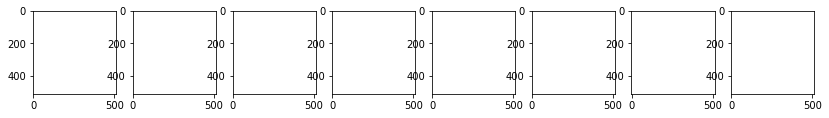

In [6]:
plt.figure(figsize=(14, 14))
for i in range(8):
    patch = next(patches)
    plt.subplot(1, 8, i+1)
    plt.imshow(patch[6], vmin=0, vmax=255)
    print("x: {}, y: {}".format(patch[0], patch[1]))

In [76]:
def test_region(region, threshold, bw=False):
    if(bw):
        gray = region
    else:
        gray = cv2.cvtColor(region, cv2.COLOR_RGB2GRAY)
    num_pixs = np.sum(gray < threshold)
    #print(num_pixs)
    print(f"tissue %: {num_pixs/(512**2)}")

In [10]:
patch1, labels = img.get_patch_with_labels(1, 1, (32000, 29000), (512, 512))
patch2, lables = img.get_patch_with_labels(1, 3, (0, 0), (512, 512))

In [11]:
patch1.shape

(512, 512, 4)

In [12]:
patch2.shape

(512, 512, 4)

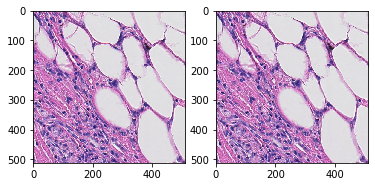

In [13]:
plt.subplot(121)
plt.imshow(patch1[:,:,0:3], vmin=0, vmax=255)
plt.subplot(122)
plt.imshow(patch1[:,:,:], vmin=0, vmax=255)

In [14]:
test_region(patch1, 83)
test_region(patch2, 83)

11175
0.042629241943359375
0
0.0


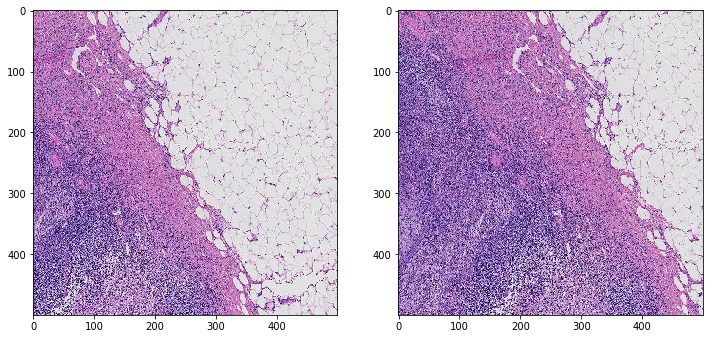

In [91]:
offset = 8
level = 4

x1 = 32000
x2 = 30000 + 2**level
y = 32000

size = 500
plt.figure(figsize=(12,12))
plt.subplot(121)
patch1 = np.array(img.stack.read_region((x1, y), level, (size, size)))[:,:,:3]
plt.imshow(patch1)
plt.subplot(122)
patch2 = np.array(img.stack.read_region((x2, y), level, (size, size)))[:,:,:3]
plt.imshow(patch2)

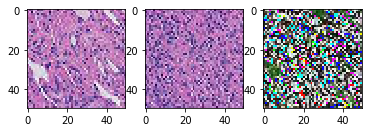

In [92]:
shift = 0
shift2 = -1
start = 100

sub_patch1 = patch1[start:start+50,start:start+50,:]
sub_patch2 = patch2[start+shift:start+50+shift,start+shift2:start+shift2+50,:]
plt.subplot(131)
plt.imshow(sub_patch1)
plt.subplot(132)
plt.imshow(sub_patch2)
plt.subplot(133)
plt.imshow(sub_patch1 - sub_patch2)

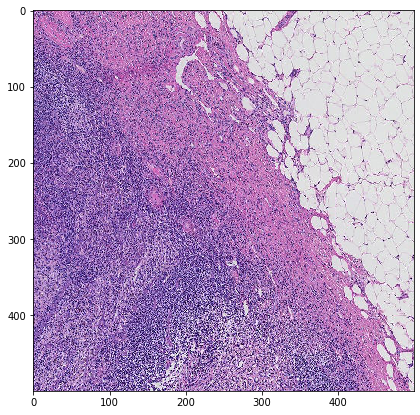

In [93]:
plt.figure(figsize=(7,7))
plt.imshow(patch2)

In [100]:
kernel = np.ones((7,7),np.uint8)
th = img.tissue_threshold()

2019-11-01 16:21:56,269 - Histocartography::IO::WSI - DEBUG - Level for desired resolution : 5
2019-11-01 16:21:56,776 - Histocartography::IO::WSI - DEBUG - Image shape after loading (2912, 3328, 3)


using current method
tissue %: 0.12287139892578125
using proposed method
tissue %: 0.6155548095703125


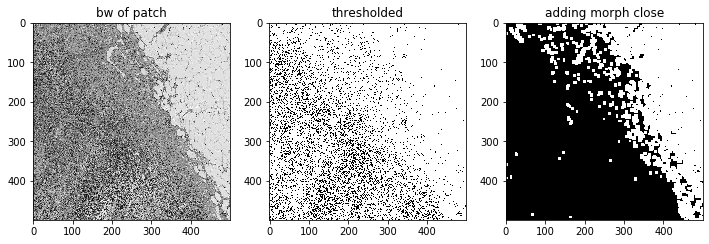

In [101]:
gray = cv2.cvtColor(patch2, cv2.COLOR_RGB2GRAY)
th, thresholded = cv2.threshold(gray, th, 255, cv2.THRESH_BINARY)
closing = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel)
plt.figure(figsize=(12, 12))
plt.subplot(131)
plt.imshow(gray, vmin=0, vmax=255, cmap='gray')
plt.title('bw of patch')
plt.subplot(132)
plt.imshow(thresholded, vmin=0, vmax=255, cmap='gray')
plt.title('thresholded')
plt.subplot(133)
plt.imshow(closing, vmin=0, vmax=255, cmap='gray')
plt.title('adding morph close')

print('using current method')
test_region(patch2, th)
print('using proposed method')
test_region(closing, th, True)

In [67]:
test_region(patch2, th)

19932
0.0760345458984375


In [69]:
num_pixs = np.sum(closing < th)
print(num_pixs)
print(num_pixs/(512**2))

168114
0.6413040161132812


In [18]:
thresholded

(83.0, array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint8))

128


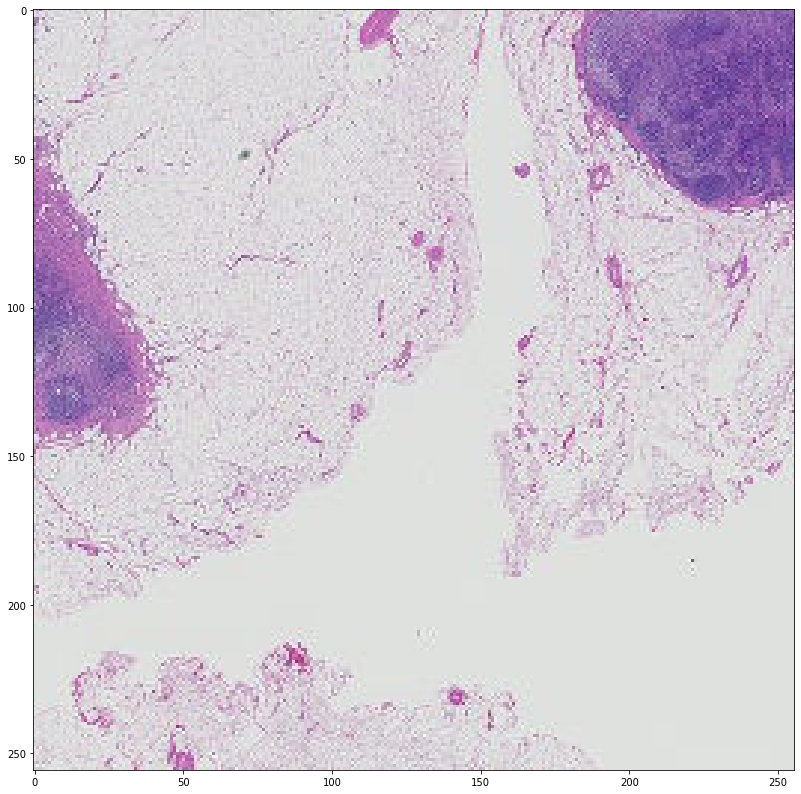

In [10]:
level = 7
size = 256

downsample = int(img.stack.properties[f'openslide.level[{level}].downsample'])
print(downsample)

y = 24576
x = 32768
# 10%
patch1 = np.array(img.stack.read_region((x, y), level, (size, size)))[:,:,:3]
plt.figure(figsize=(14,14))
plt.imshow(patch1)

In [73]:
img.tissue_threshold()

2019-11-01 16:02:05,731 - Histocartography::IO::WSI - DEBUG - Level for desired resolution : 5
2019-11-01 16:02:06,201 - Histocartography::IO::WSI - DEBUG - Image shape after loading (2912, 3328, 3)


83.0